In [1]:
## Importam les llibreries necessaries
import torch
import torch.nn as nn
import math
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Un nou problema

El problema que volem resoldre és la creació d'una xarxa que sigui capaç de realitzar la predicció del valor mitjà de l'habitatge per als districtes de Califòrnia. Aquest tipus de conjunts es coneixen amb el nom d'exemples de joguina, ja que estan preparats per aconseguir bons resultats amb models relativament simples,.

 Cada observació és un grup de blocs censals. La variable objectiu és el valor mitjà de l'habitatge en 100.000 USD l'any 1990 i hi ha 8 característiques d'entrada, cadascuna que descriu alguna cosa sobre la casa.

 - MedInc: ingressos mitjans al grup de blocs.
 - HouseAge: edat mitjana dels blocs.
 - AveRooms: nombre mitjà d'habitacions per llar.
 - AveBedrms: nombre mitjà d'habitacions per llar.
 - Population: nombre de persones que viuen als blocs.
 - AveOccup: nombre mitjà de membres de la llar.
 - Latitude: latitud del centroide del grup de blocs.
 - Longitude: longitud del centroide del grup de blocs.

Aquestes dades tenen la particularitat que diverses característiques es troben en una escala molt diferent. Per exemple, el nombre d'habitacions per habitatge acostuma a ser petit, però la població per bloc sol ser gran. A més, la majoria de les característiques haurien de ser positives, però la longitud ha de ser negativa, recordau que som a Califòrnia. El maneig d'aquesta diversitat de dades és un repte per a alguns models d'aprenentatge automàtic i l'hem de resoldre.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Obtenim les dades
data = fetch_california_housing()
X, y = data.data, data.target
 
# Les dividim en els dos conjunts que hem mencionat. El d'entrenament té el 70% de les dades
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Convertim les estructures Numpy a tensors compatibles amb Pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

## Definició de la xarxa



In [3]:
model = nn.Sequential((torch.nn.Linear(8, 1)))

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Entrenament

L'entrenament es duu a terme en forma de bucle, el nombre de cops que s'ha de realitzar aquest bucle és un hiperparàmetre que nosaltres haurem de decidir. 

A cada iteració de l'entrenament la xarxa realitza una predicció sobre les dades d'entrada i després es calcula **l'error mitjà** de totes les mostres emprant la funció de pèrdua com a referència d'aquesta manera es sap com s'han de modificar els pesos de la xarxa per aconseguir un bon resultat final. 

**Batches**

Per tal d'aconseguir un equilibri entre el gran cost que suposaria fer una predicció de cada observació de manera individual i la poca importància que tendría cada observació en la mitja de l'error si es fessin totes les prediccions de cop, es sol cercar un camí intermedi que consisteix a dividir el conjunt de dades en grups anomenats _batches_. 



MSE amb el millor model: 0.6153200268745422


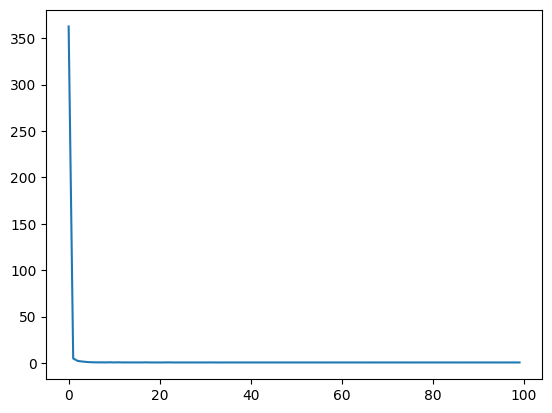

In [5]:
import copy
import numpy as np
import torch


n_epochs = 100   # nombre d'iteracions del bucle d'entrenament
batch_size = 10  # nombre d'elements que té cada batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Ens servirà per guardar el millor model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train() # Posam el model en mode entrenament 
     
    for start in batch_start: # 
        # agafam un batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # realitzem la predicció (passa envant)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # realitzem la passa enrere
        optimizer.zero_grad()
        loss.backward()
        # actualitzem els pesos
        optimizer.step()

    # avaluem el model
    model.eval()  # Mode avaluació de la xarxa
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    if mse < best_mse: # si és el millor en realitzem una copia
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# carregam el millor model
model.load_state_dict(best_weights)
print(f"MSE amb el millor model: {best_mse}")
plt.plot(history)
plt.show()

## Exercici

1. Prova noves configuracions de la xarxa afegint capes ocultes al `model`. Quina és la configuració que dona el menor error en el conjunt de test? 
2. En la descripció del conjunt de dades hem dit que la seva particularitat és que les dades estan a diferent escala. Torna a realitzar el procés de càrrega de dades, però abans de transformar-les a tensors, prova de normalitzar-les. Després, entrena un nou model i compara els resultats obtinguts.


MSE amb el millor model: 0.30249840021133423


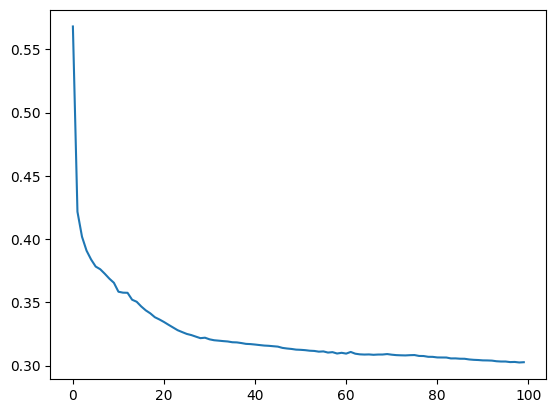

In [4]:
import copy
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Obtenim les dades
data = fetch_california_housing()
X, y = data.data, data.target
 
# Les dividim en els dos conjunts que hem mencionat. El d'entrenament té el 70% de les dades
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertim les estructures Numpy a tensors compatibles amb Pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

model = nn.Sequential(torch.nn.Linear(8, 12),
                      torch.nn.ReLU(),
                        torch.nn.Linear(12, 6),
                        torch.nn.ReLU(),
                      torch.nn.Linear(6, 1)
                      )

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100   # nombre d'iteracions del bucle d'entrenament
batch_size = 10  # nombre d'elements que té cada batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Ens servirà per guardar el millor model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train() # Posam el model en mode entrenament 
     
    for start in batch_start: # 
        # agafam un batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # realitzem la predicció (passa envant)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # realitzem la passa enrere
        optimizer.zero_grad()
        loss.backward()
        # actualitzem els pesos
        optimizer.step()

    # avaluem el model
    model.eval()  # Mode avaluació de la xarxa
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    if mse < best_mse: # si és el millor en realitzem una copia
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# carregam el millor model
model.load_state_dict(best_weights)
print(f"MSE amb el millor model: {best_mse}")
plt.plot(history)
plt.show()